<a href="https://colab.research.google.com/github/eva7wandb/Eva7_Weights_Heist/blob/main/S6/run_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
! git clone https://github.com/eva7wandb/Eva7_Weights_Heist

Cloning into 'Eva7_Weights_Heist'...
remote: Enumerating objects: 255, done.
remote: Counting objects: 100% (255/255), done.
remote: Compressing objects: 100% (239/239), done.
remote: Total 255 (delta 103), reused 34 (delta 8), pack-reused 0
Receiving objects: 100% (255/255), 2.04 MiB | 9.40 MiB/s, done.
Resolving deltas: 100% (103/103), done.


In [4]:
! ls ./Eva7_Weights_Heist/S6

datasets  README.md  run_experiments.ipynb	  usage_notebook.ipynb
models	  resources  updated_Normalizations.xlsx  utils


In [5]:
import sys
sys.path.append('./Eva7_Weights_Heist/S6/')

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary

from utils.general_utils import setup_env
from utils.training import train_model
from utils.testing import test_model
from utils.misclassified import (
    get_incorrect_preds, plot_incorrect_preds
)
from datasets.mnist import MNIST
from models.model import Net

In [7]:
cuda, device = setup_env()
print(cuda, device)

True cuda


In [8]:
## Load Dataset
train_dataloader, test_dataloader = MNIST(cuda).get_dataloader()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /tmp/data/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /tmp/data/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /tmp/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /tmp/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid poten

In [9]:
logs = []

## MODEL 0
- Batch Norm Only

In [10]:
exp_name = 'batch norm only'
model = Net(
    batch_norm=True,
    dropout_value=0.01,
).to(device)
summary(model, input_size=(1, 28, 28))

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=8, gamma=0.01)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_batch_loss, train_batch_acc = train_model(
        model, device, train_dataloader, optimizer, epoch
    )
    test_loss, test_acc = test_model(model, device, test_dataloader)
    scheduler.step()
    
    logs.append({
        'epoch': epoch,
        'train_losses': np.mean(train_batch_loss),
        'test_losses': test_loss,
        'train_acc': np.mean(train_batch_acc),
        'test_acc': test_acc,
        'exp': exp_name,
    })

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
        conv_block-5            [-1, 8, 26, 26]               0
            Conv2d-6           [-1, 16, 24, 24]           1,152
              ReLU-7           [-1, 16, 24, 24]               0
       BatchNorm2d-8           [-1, 16, 24, 24]              32
           Dropout-9           [-1, 16, 24, 24]               0
       conv_block-10           [-1, 16, 24, 24]               0
           Conv2d-11            [-1, 8, 24, 24]             128
       conv_block-12            [-1, 8, 24, 24]               0
        MaxPool2d-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1, 12,

  0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.05909965932369232 Batch_id=937 Accuracy=94.53: 100%|██████████| 938/938 [00:26<00:00, 35.45it/s]



Test set: Average loss: 0.0653, Accuracy: 9780/10000 (97.80%)

EPOCH: 1


Loss=0.025678401812911034 Batch_id=937 Accuracy=97.82: 100%|██████████| 938/938 [00:26<00:00, 35.30it/s]



Test set: Average loss: 0.0443, Accuracy: 9862/10000 (98.62%)

EPOCH: 2


Loss=0.12008417397737503 Batch_id=937 Accuracy=98.25: 100%|██████████| 938/938 [00:26<00:00, 35.42it/s]



Test set: Average loss: 0.0436, Accuracy: 9861/10000 (98.61%)

EPOCH: 3


Loss=0.08151084184646606 Batch_id=937 Accuracy=98.55: 100%|██████████| 938/938 [00:26<00:00, 35.19it/s]



Test set: Average loss: 0.0463, Accuracy: 9847/10000 (98.47%)

EPOCH: 4


Loss=0.0022332891821861267 Batch_id=937 Accuracy=98.53: 100%|██████████| 938/938 [00:26<00:00, 35.27it/s]



Test set: Average loss: 0.0340, Accuracy: 9896/10000 (98.96%)

EPOCH: 5


Loss=0.0007309498614631593 Batch_id=937 Accuracy=98.72: 100%|██████████| 938/938 [00:26<00:00, 35.26it/s]



Test set: Average loss: 0.0306, Accuracy: 9897/10000 (98.97%)

EPOCH: 6


Loss=0.1420542299747467 Batch_id=937 Accuracy=98.74: 100%|██████████| 938/938 [00:26<00:00, 35.08it/s]



Test set: Average loss: 0.0311, Accuracy: 9892/10000 (98.92%)

EPOCH: 7


Loss=0.0014320514164865017 Batch_id=937 Accuracy=98.80: 100%|██████████| 938/938 [00:26<00:00, 35.16it/s]



Test set: Average loss: 0.0277, Accuracy: 9912/10000 (99.12%)

EPOCH: 8


Loss=0.036894943565130234 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [00:26<00:00, 35.16it/s]



Test set: Average loss: 0.0237, Accuracy: 9922/10000 (99.22%)

EPOCH: 9


Loss=0.025263292714953423 Batch_id=937 Accuracy=99.16: 100%|██████████| 938/938 [00:26<00:00, 35.20it/s]



Test set: Average loss: 0.0230, Accuracy: 9925/10000 (99.25%)

EPOCH: 10


Loss=0.06640811264514923 Batch_id=937 Accuracy=99.22: 100%|██████████| 938/938 [00:26<00:00, 35.21it/s]



Test set: Average loss: 0.0218, Accuracy: 9928/10000 (99.28%)

EPOCH: 11


Loss=0.007146415300667286 Batch_id=937 Accuracy=99.24: 100%|██████████| 938/938 [00:26<00:00, 35.18it/s]



Test set: Average loss: 0.0213, Accuracy: 9931/10000 (99.31%)

EPOCH: 12


Loss=0.00419428339228034 Batch_id=937 Accuracy=99.22: 100%|██████████| 938/938 [00:26<00:00, 35.19it/s]



Test set: Average loss: 0.0215, Accuracy: 9927/10000 (99.27%)

EPOCH: 13


Loss=0.0093387421220541 Batch_id=937 Accuracy=99.24: 100%|██████████| 938/938 [00:26<00:00, 35.01it/s]



Test set: Average loss: 0.0206, Accuracy: 9936/10000 (99.36%)

EPOCH: 14


Loss=0.0011647806968539953 Batch_id=937 Accuracy=99.28: 100%|██████████| 938/938 [00:26<00:00, 34.91it/s]



Test set: Average loss: 0.0206, Accuracy: 9938/10000 (99.38%)

EPOCH: 15


Loss=0.05701332539319992 Batch_id=937 Accuracy=99.28: 100%|██████████| 938/938 [00:26<00:00, 34.83it/s]



Test set: Average loss: 0.0204, Accuracy: 9935/10000 (99.35%)

EPOCH: 16


Loss=0.023818474262952805 Batch_id=937 Accuracy=99.31: 100%|██████████| 938/938 [00:26<00:00, 34.86it/s]



Test set: Average loss: 0.0206, Accuracy: 9934/10000 (99.34%)

EPOCH: 17


Loss=0.0014959785621613264 Batch_id=937 Accuracy=99.32: 100%|██████████| 938/938 [00:26<00:00, 34.79it/s]



Test set: Average loss: 0.0202, Accuracy: 9935/10000 (99.35%)

EPOCH: 18


Loss=0.005210393574088812 Batch_id=937 Accuracy=99.25: 100%|██████████| 938/938 [00:27<00:00, 34.49it/s]



Test set: Average loss: 0.0210, Accuracy: 9931/10000 (99.31%)

EPOCH: 19


Loss=0.02067515440285206 Batch_id=937 Accuracy=99.24: 100%|██████████| 938/938 [00:27<00:00, 34.49it/s]



Test set: Average loss: 0.0203, Accuracy: 9936/10000 (99.36%)



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Classes in order Actual and Predicted


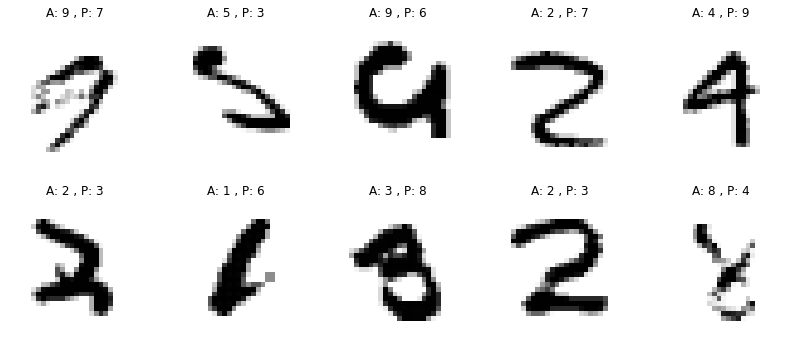

In [11]:
(
    true_wrong, incorrect_examples, pred_wrong
 ) = get_incorrect_preds(model, test_dataloader)
plot_incorrect_preds(true_wrong, incorrect_examples, pred_wrong)

In [12]:
del model, optimizer, scheduler

## MODEL 1
- Group Normalization Only

In [13]:
exp_name = 'Group norm only'
model = Net(
    batch_norm=False,
    layer_norm=False,
    group_norm=True,
    group_norm_groups=2,
).to(device)
summary(model, input_size=(1, 28, 28))

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=8, gamma=0.01)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_batch_loss, train_batch_acc = train_model(
        model, device, train_dataloader, optimizer, epoch
    )
    test_loss, test_acc = test_model(model, device, test_dataloader)
    scheduler.step()
    
    logs.append({
        'epoch': epoch,
        'train_losses': np.mean(train_batch_loss),
        'test_losses': test_loss,
        'train_acc': np.mean(train_batch_acc),
        'test_acc': test_acc,
        'exp': exp_name,
    })

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
         GroupNorm-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
        conv_block-5            [-1, 8, 26, 26]               0
            Conv2d-6           [-1, 16, 24, 24]           1,152
              ReLU-7           [-1, 16, 24, 24]               0
         GroupNorm-8           [-1, 16, 24, 24]              32
           Dropout-9           [-1, 16, 24, 24]               0
       conv_block-10           [-1, 16, 24, 24]               0
           Conv2d-11            [-1, 8, 24, 24]             128
       conv_block-12            [-1, 8, 24, 24]               0
        MaxPool2d-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1, 12,

  0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.024549372494220734 Batch_id=937 Accuracy=92.11: 100%|██████████| 938/938 [00:26<00:00, 35.11it/s]



Test set: Average loss: 0.0658, Accuracy: 9804/10000 (98.04%)

EPOCH: 1


Loss=0.035606749355793 Batch_id=937 Accuracy=97.34: 100%|██████████| 938/938 [00:26<00:00, 34.92it/s]



Test set: Average loss: 0.0474, Accuracy: 9849/10000 (98.49%)

EPOCH: 2


Loss=0.16351933777332306 Batch_id=937 Accuracy=97.98: 100%|██████████| 938/938 [00:27<00:00, 34.61it/s]



Test set: Average loss: 0.0386, Accuracy: 9877/10000 (98.77%)

EPOCH: 3


Loss=0.07831300795078278 Batch_id=937 Accuracy=98.23: 100%|██████████| 938/938 [00:26<00:00, 34.88it/s]



Test set: Average loss: 0.0435, Accuracy: 9848/10000 (98.48%)

EPOCH: 4


Loss=0.025088762864470482 Batch_id=937 Accuracy=98.41: 100%|██████████| 938/938 [00:26<00:00, 35.06it/s]



Test set: Average loss: 0.0388, Accuracy: 9875/10000 (98.75%)

EPOCH: 5


Loss=0.0010746546322479844 Batch_id=937 Accuracy=98.52: 100%|██████████| 938/938 [00:26<00:00, 35.03it/s]



Test set: Average loss: 0.0360, Accuracy: 9884/10000 (98.84%)

EPOCH: 6


Loss=0.034164294600486755 Batch_id=937 Accuracy=98.54: 100%|██████████| 938/938 [00:26<00:00, 35.00it/s]



Test set: Average loss: 0.0336, Accuracy: 9892/10000 (98.92%)

EPOCH: 7


Loss=0.00459109665825963 Batch_id=937 Accuracy=98.69: 100%|██████████| 938/938 [00:26<00:00, 34.96it/s]



Test set: Average loss: 0.0359, Accuracy: 9882/10000 (98.82%)

EPOCH: 8


Loss=0.038512445986270905 Batch_id=937 Accuracy=98.88: 100%|██████████| 938/938 [00:26<00:00, 35.02it/s]



Test set: Average loss: 0.0269, Accuracy: 9911/10000 (99.11%)

EPOCH: 9


Loss=0.08329692482948303 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:26<00:00, 35.26it/s]



Test set: Average loss: 0.0259, Accuracy: 9915/10000 (99.15%)

EPOCH: 10


Loss=0.008717711083590984 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [00:26<00:00, 35.18it/s]



Test set: Average loss: 0.0255, Accuracy: 9918/10000 (99.18%)

EPOCH: 11


Loss=0.06510157883167267 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:26<00:00, 35.12it/s]



Test set: Average loss: 0.0252, Accuracy: 9917/10000 (99.17%)

EPOCH: 12


Loss=0.002139799064025283 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [00:26<00:00, 35.17it/s]



Test set: Average loss: 0.0249, Accuracy: 9914/10000 (99.14%)

EPOCH: 13


Loss=0.0004920845967717469 Batch_id=937 Accuracy=99.16: 100%|██████████| 938/938 [00:26<00:00, 35.31it/s]



Test set: Average loss: 0.0248, Accuracy: 9916/10000 (99.16%)

EPOCH: 14


Loss=0.0009368070750497282 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [00:26<00:00, 34.80it/s]



Test set: Average loss: 0.0245, Accuracy: 9921/10000 (99.21%)

EPOCH: 15


Loss=0.0035324571654200554 Batch_id=937 Accuracy=99.19: 100%|██████████| 938/938 [00:27<00:00, 34.66it/s]



Test set: Average loss: 0.0243, Accuracy: 9922/10000 (99.22%)

EPOCH: 16


Loss=0.27536895871162415 Batch_id=937 Accuracy=99.15: 100%|██████████| 938/938 [00:27<00:00, 34.50it/s]



Test set: Average loss: 0.0243, Accuracy: 9922/10000 (99.22%)

EPOCH: 17


Loss=0.0753411203622818 Batch_id=937 Accuracy=99.19: 100%|██████████| 938/938 [00:26<00:00, 35.25it/s]



Test set: Average loss: 0.0243, Accuracy: 9922/10000 (99.22%)

EPOCH: 18


Loss=0.009338273666799068 Batch_id=937 Accuracy=99.20: 100%|██████████| 938/938 [00:26<00:00, 35.06it/s]



Test set: Average loss: 0.0243, Accuracy: 9921/10000 (99.21%)

EPOCH: 19


Loss=0.0028284857980906963 Batch_id=937 Accuracy=99.21: 100%|██████████| 938/938 [00:26<00:00, 35.02it/s]



Test set: Average loss: 0.0243, Accuracy: 9921/10000 (99.21%)



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Classes in order Actual and Predicted


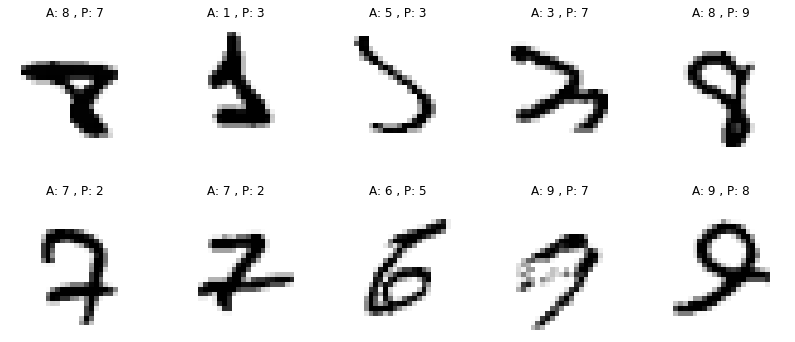

In [14]:
(
    true_wrong, incorrect_examples, pred_wrong
 ) = get_incorrect_preds(model, test_dataloader)
plot_incorrect_preds(true_wrong, incorrect_examples, pred_wrong)

In [15]:
del model, optimizer, scheduler

## MODEL 2
-  Layer Normalization Only

In [16]:
exp_name = 'Layer norm only'
model = Net(
    batch_norm=False,
    layer_norm=True,
    group_norm=False,
).to(device)
summary(model, input_size=(1, 28, 28))

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=8, gamma=0.01)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_batch_loss, train_batch_acc = train_model(
        model, device, train_dataloader, optimizer, epoch
    )
    test_loss, test_acc = test_model(model, device, test_dataloader)
    scheduler.step()
    
    logs.append({
        'epoch': epoch,
        'train_losses': np.mean(train_batch_loss),
        'test_losses': test_loss,
        'train_acc': np.mean(train_batch_acc),
        'test_acc': test_acc,
        'exp': exp_name,
    })

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
         GroupNorm-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
        conv_block-5            [-1, 8, 26, 26]               0
            Conv2d-6           [-1, 16, 24, 24]           1,152
              ReLU-7           [-1, 16, 24, 24]               0
         GroupNorm-8           [-1, 16, 24, 24]              32
           Dropout-9           [-1, 16, 24, 24]               0
       conv_block-10           [-1, 16, 24, 24]               0
           Conv2d-11            [-1, 8, 24, 24]             128
       conv_block-12            [-1, 8, 24, 24]               0
        MaxPool2d-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1, 12,

  0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.08105593919754028 Batch_id=937 Accuracy=90.94: 100%|██████████| 938/938 [00:26<00:00, 35.85it/s]



Test set: Average loss: 0.0761, Accuracy: 9769/10000 (97.69%)

EPOCH: 1


Loss=0.033913664519786835 Batch_id=937 Accuracy=97.35: 100%|██████████| 938/938 [00:26<00:00, 35.89it/s]



Test set: Average loss: 0.0768, Accuracy: 9746/10000 (97.46%)

EPOCH: 2


Loss=0.027085281908512115 Batch_id=937 Accuracy=97.92: 100%|██████████| 938/938 [00:26<00:00, 35.56it/s]



Test set: Average loss: 0.0397, Accuracy: 9871/10000 (98.71%)

EPOCH: 3


Loss=0.14498451352119446 Batch_id=937 Accuracy=98.26: 100%|██████████| 938/938 [00:26<00:00, 35.77it/s]



Test set: Average loss: 0.0428, Accuracy: 9859/10000 (98.59%)

EPOCH: 4


Loss=0.01206617895513773 Batch_id=937 Accuracy=98.45: 100%|██████████| 938/938 [00:26<00:00, 35.98it/s]



Test set: Average loss: 0.0336, Accuracy: 9894/10000 (98.94%)

EPOCH: 5


Loss=0.005297000985592604 Batch_id=937 Accuracy=98.62: 100%|██████████| 938/938 [00:26<00:00, 35.63it/s]



Test set: Average loss: 0.0339, Accuracy: 9897/10000 (98.97%)

EPOCH: 6


Loss=0.025921419262886047 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [00:26<00:00, 35.72it/s]



Test set: Average loss: 0.0327, Accuracy: 9896/10000 (98.96%)

EPOCH: 7


Loss=0.004468852654099464 Batch_id=937 Accuracy=98.70: 100%|██████████| 938/938 [00:26<00:00, 35.71it/s]



Test set: Average loss: 0.0342, Accuracy: 9889/10000 (98.89%)

EPOCH: 8


Loss=0.004045085981488228 Batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [00:26<00:00, 35.56it/s]



Test set: Average loss: 0.0264, Accuracy: 9919/10000 (99.19%)

EPOCH: 9


Loss=0.0065984176471829414 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [00:26<00:00, 35.65it/s]



Test set: Average loss: 0.0244, Accuracy: 9925/10000 (99.25%)

EPOCH: 10


Loss=0.05894468352198601 Batch_id=937 Accuracy=99.22: 100%|██████████| 938/938 [00:26<00:00, 35.39it/s]



Test set: Average loss: 0.0233, Accuracy: 9928/10000 (99.28%)

EPOCH: 11


Loss=0.000514395534992218 Batch_id=937 Accuracy=99.24: 100%|██████████| 938/938 [00:26<00:00, 35.66it/s]



Test set: Average loss: 0.0228, Accuracy: 9930/10000 (99.30%)

EPOCH: 12


Loss=0.0028658832889050245 Batch_id=937 Accuracy=99.21: 100%|██████████| 938/938 [00:26<00:00, 35.37it/s]



Test set: Average loss: 0.0224, Accuracy: 9932/10000 (99.32%)

EPOCH: 13


Loss=0.013346563093364239 Batch_id=937 Accuracy=99.23: 100%|██████████| 938/938 [00:26<00:00, 34.92it/s]



Test set: Average loss: 0.0220, Accuracy: 9934/10000 (99.34%)

EPOCH: 14


Loss=0.07372375577688217 Batch_id=937 Accuracy=99.26: 100%|██████████| 938/938 [00:26<00:00, 34.87it/s]



Test set: Average loss: 0.0218, Accuracy: 9936/10000 (99.36%)

EPOCH: 15


Loss=0.0004132725880481303 Batch_id=937 Accuracy=99.26: 100%|██████████| 938/938 [00:26<00:00, 35.11it/s]



Test set: Average loss: 0.0216, Accuracy: 9935/10000 (99.35%)

EPOCH: 16


Loss=0.0037481870967894793 Batch_id=937 Accuracy=99.29: 100%|██████████| 938/938 [00:26<00:00, 35.04it/s]



Test set: Average loss: 0.0216, Accuracy: 9936/10000 (99.36%)

EPOCH: 17


Loss=0.04555888473987579 Batch_id=937 Accuracy=99.28: 100%|██████████| 938/938 [00:26<00:00, 35.19it/s]



Test set: Average loss: 0.0216, Accuracy: 9936/10000 (99.36%)

EPOCH: 18


Loss=0.012085157446563244 Batch_id=937 Accuracy=99.25: 100%|██████████| 938/938 [00:26<00:00, 35.30it/s]



Test set: Average loss: 0.0216, Accuracy: 9936/10000 (99.36%)

EPOCH: 19


Loss=0.06663137674331665 Batch_id=937 Accuracy=99.30: 100%|██████████| 938/938 [00:26<00:00, 35.23it/s]



Test set: Average loss: 0.0216, Accuracy: 9936/10000 (99.36%)



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Classes in order Actual and Predicted


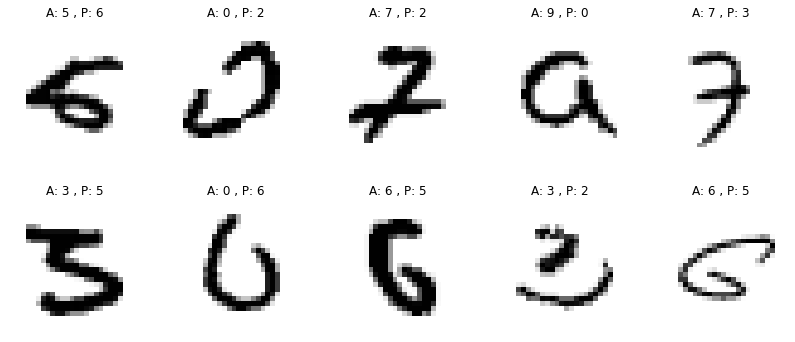

In [17]:
(
    true_wrong, incorrect_examples, pred_wrong
 ) = get_incorrect_preds(model, test_dataloader)
plot_incorrect_preds(true_wrong, incorrect_examples, pred_wrong)

In [18]:
del model, optimizer, scheduler

## MODEL 3
- Batch Normalization and L1

In [28]:
?? train_model

In [19]:
exp_name = 'Batch norm and L1'
model = Net(
    batch_norm=True,
    layer_norm=False,
    group_norm=False,
).to(device)
summary(model, input_size=(1, 28, 28))

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=8, gamma=0.01)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_batch_loss, train_batch_acc = train_model(
        model, device, train_dataloader, optimizer, epoch, L1=True,
    )
    test_loss, test_acc = test_model(model, device, test_dataloader)
    scheduler.step()
    
    logs.append({
        'epoch': epoch,
        'train_losses': np.mean(train_batch_loss),
        'test_losses': test_loss,
        'train_acc': np.mean(train_batch_acc),
        'test_acc': test_acc,
        'exp': exp_name,
    })

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
        conv_block-5            [-1, 8, 26, 26]               0
            Conv2d-6           [-1, 16, 24, 24]           1,152
              ReLU-7           [-1, 16, 24, 24]               0
       BatchNorm2d-8           [-1, 16, 24, 24]              32
           Dropout-9           [-1, 16, 24, 24]               0
       conv_block-10           [-1, 16, 24, 24]               0
           Conv2d-11            [-1, 8, 24, 24]             128
       conv_block-12            [-1, 8, 24, 24]               0
        MaxPool2d-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1, 12,

  0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=7.434976100921631 Batch_id=937 Accuracy=11.28: 100%|██████████| 938/938 [00:30<00:00, 31.25it/s]



Test set: Average loss: 2.3026, Accuracy: 980/10000 (9.80%)

EPOCH: 1


Loss=7.326896667480469 Batch_id=937 Accuracy=9.93: 100%|██████████| 938/938 [00:29<00:00, 31.42it/s]



Test set: Average loss: 2.3026, Accuracy: 1028/10000 (10.28%)

EPOCH: 2


Loss=7.469926834106445 Batch_id=937 Accuracy=10.33: 100%|██████████| 938/938 [00:30<00:00, 31.12it/s]



Test set: Average loss: 2.3026, Accuracy: 1032/10000 (10.32%)

EPOCH: 3


Loss=7.432509899139404 Batch_id=937 Accuracy=9.98: 100%|██████████| 938/938 [00:30<00:00, 30.84it/s]



Test set: Average loss: 2.3026, Accuracy: 1135/10000 (11.35%)

EPOCH: 4


Loss=7.4946794509887695 Batch_id=937 Accuracy=9.92: 100%|██████████| 938/938 [00:29<00:00, 31.27it/s]



Test set: Average loss: 2.3026, Accuracy: 958/10000 (9.58%)

EPOCH: 5


Loss=7.493453025817871 Batch_id=937 Accuracy=9.84: 100%|██████████| 938/938 [00:30<00:00, 31.11it/s]



Test set: Average loss: 2.3026, Accuracy: 1135/10000 (11.35%)

EPOCH: 6


Loss=7.436503887176514 Batch_id=937 Accuracy=9.94: 100%|██████████| 938/938 [00:30<00:00, 30.90it/s]



Test set: Average loss: 2.3026, Accuracy: 1135/10000 (11.35%)

EPOCH: 7


Loss=7.486934661865234 Batch_id=937 Accuracy=9.87: 100%|██████████| 938/938 [00:30<00:00, 31.12it/s]



Test set: Average loss: 2.3026, Accuracy: 982/10000 (9.82%)

EPOCH: 8


Loss=2.359100341796875 Batch_id=937 Accuracy=9.87: 100%|██████████| 938/938 [00:30<00:00, 31.12it/s]



Test set: Average loss: 2.3026, Accuracy: 980/10000 (9.80%)

EPOCH: 9


Loss=2.359499216079712 Batch_id=937 Accuracy=9.87: 100%|██████████| 938/938 [00:30<00:00, 31.09it/s]



Test set: Average loss: 2.3026, Accuracy: 980/10000 (9.80%)

EPOCH: 10


Loss=2.359586000442505 Batch_id=937 Accuracy=9.87: 100%|██████████| 938/938 [00:30<00:00, 31.03it/s]



Test set: Average loss: 2.3026, Accuracy: 980/10000 (9.80%)

EPOCH: 11


Loss=2.3579297065734863 Batch_id=937 Accuracy=9.87: 100%|██████████| 938/938 [00:30<00:00, 31.07it/s]



Test set: Average loss: 2.3026, Accuracy: 980/10000 (9.80%)

EPOCH: 12


Loss=2.359555244445801 Batch_id=937 Accuracy=9.87: 100%|██████████| 938/938 [00:30<00:00, 31.06it/s]



Test set: Average loss: 2.3026, Accuracy: 980/10000 (9.80%)

EPOCH: 13


Loss=2.3574907779693604 Batch_id=937 Accuracy=9.87: 100%|██████████| 938/938 [00:30<00:00, 31.07it/s]



Test set: Average loss: 2.3026, Accuracy: 980/10000 (9.80%)

EPOCH: 14


Loss=2.3588883876800537 Batch_id=937 Accuracy=9.87: 100%|██████████| 938/938 [00:30<00:00, 31.14it/s]



Test set: Average loss: 2.3026, Accuracy: 980/10000 (9.80%)

EPOCH: 15


Loss=2.3583731651306152 Batch_id=937 Accuracy=9.87: 100%|██████████| 938/938 [00:30<00:00, 30.70it/s]



Test set: Average loss: 2.3026, Accuracy: 980/10000 (9.80%)

EPOCH: 16


Loss=2.303149461746216 Batch_id=937 Accuracy=9.87: 100%|██████████| 938/938 [00:30<00:00, 30.75it/s]



Test set: Average loss: 2.3026, Accuracy: 980/10000 (9.80%)

EPOCH: 17


Loss=2.3031463623046875 Batch_id=937 Accuracy=9.87: 100%|██████████| 938/938 [00:30<00:00, 30.69it/s]



Test set: Average loss: 2.3026, Accuracy: 980/10000 (9.80%)

EPOCH: 18


Loss=2.303152561187744 Batch_id=937 Accuracy=9.87: 100%|██████████| 938/938 [00:30<00:00, 30.74it/s]



Test set: Average loss: 2.3026, Accuracy: 980/10000 (9.80%)

EPOCH: 19


Loss=2.3031420707702637 Batch_id=937 Accuracy=9.87: 100%|██████████| 938/938 [00:30<00:00, 30.81it/s]



Test set: Average loss: 2.3026, Accuracy: 980/10000 (9.80%)



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Classes in order Actual and Predicted


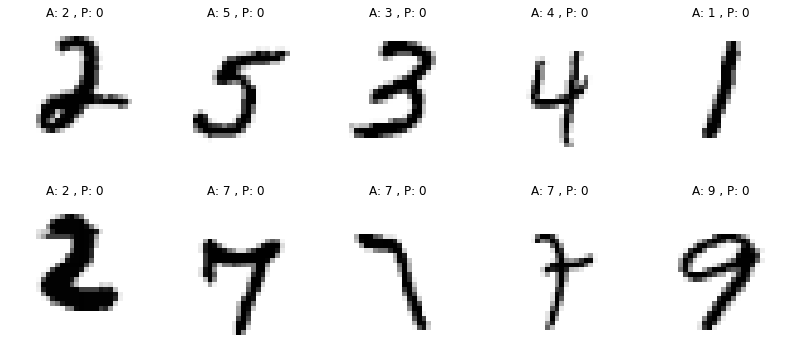

In [20]:
(
    true_wrong, incorrect_examples, pred_wrong
 ) = get_incorrect_preds(model, test_dataloader)
plot_incorrect_preds(true_wrong, incorrect_examples, pred_wrong)

In [21]:
del model, optimizer, scheduler

# Model 4
- smaller lambda for L1 (prev - 0.01 to now - 0.001)

In [29]:
exp_name = 'Batch norm and L1 (low lambda)'
model = Net(
    batch_norm=True,
    layer_norm=False,
    group_norm=False,
).to(device)
summary(model, input_size=(1, 28, 28))

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=8, gamma=0.01)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_batch_loss, train_batch_acc = train_model(
        model, device, train_dataloader, optimizer, epoch, L1=True, l1_lambda=0.001
    )
    test_loss, test_acc = test_model(model, device, test_dataloader)
    scheduler.step()
    
    logs.append({
        'epoch': epoch,
        'train_losses': np.mean(train_batch_loss),
        'test_losses': test_loss,
        'train_acc': np.mean(train_batch_acc),
        'test_acc': test_acc,
        'exp': exp_name,
    })

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
        conv_block-5            [-1, 8, 26, 26]               0
            Conv2d-6           [-1, 16, 24, 24]           1,152
              ReLU-7           [-1, 16, 24, 24]               0
       BatchNorm2d-8           [-1, 16, 24, 24]              32
           Dropout-9           [-1, 16, 24, 24]               0
       conv_block-10           [-1, 16, 24, 24]               0
           Conv2d-11            [-1, 8, 24, 24]             128
       conv_block-12            [-1, 8, 24, 24]               0
        MaxPool2d-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1, 12,

  0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=1.921111822128296 Batch_id=937 Accuracy=83.80: 100%|██████████| 938/938 [00:30<00:00, 30.78it/s]



Test set: Average loss: 2.5612, Accuracy: 2947/10000 (29.47%)

EPOCH: 1


Loss=2.704777956008911 Batch_id=937 Accuracy=84.87: 100%|██████████| 938/938 [00:30<00:00, 30.74it/s]



Test set: Average loss: 1.9571, Accuracy: 4408/10000 (44.08%)

EPOCH: 2


Loss=2.095813751220703 Batch_id=937 Accuracy=84.27: 100%|██████████| 938/938 [00:30<00:00, 31.03it/s]



Test set: Average loss: 1.0835, Accuracy: 6579/10000 (65.79%)

EPOCH: 3


Loss=1.9960055351257324 Batch_id=937 Accuracy=86.55: 100%|██████████| 938/938 [00:30<00:00, 30.85it/s]



Test set: Average loss: 0.9060, Accuracy: 6937/10000 (69.37%)

EPOCH: 4


Loss=2.0641491413116455 Batch_id=937 Accuracy=85.45: 100%|██████████| 938/938 [00:30<00:00, 30.99it/s]



Test set: Average loss: 1.5756, Accuracy: 4187/10000 (41.87%)

EPOCH: 5


Loss=1.4646997451782227 Batch_id=937 Accuracy=85.67: 100%|██████████| 938/938 [00:30<00:00, 31.12it/s]



Test set: Average loss: 1.3487, Accuracy: 6615/10000 (66.15%)

EPOCH: 6


Loss=1.4850457906723022 Batch_id=937 Accuracy=82.10: 100%|██████████| 938/938 [00:30<00:00, 31.11it/s]



Test set: Average loss: 0.8269, Accuracy: 7204/10000 (72.04%)

EPOCH: 7


Loss=4.606568336486816 Batch_id=937 Accuracy=83.83: 100%|██████████| 938/938 [00:30<00:00, 30.97it/s]



Test set: Average loss: 1.4325, Accuracy: 5108/10000 (51.08%)

EPOCH: 8


Loss=4.086233139038086 Batch_id=937 Accuracy=89.18: 100%|██████████| 938/938 [00:30<00:00, 30.91it/s]



Test set: Average loss: 0.2890, Accuracy: 9152/10000 (91.52%)

EPOCH: 9


Loss=4.1548171043396 Batch_id=937 Accuracy=89.96: 100%|██████████| 938/938 [00:30<00:00, 31.06it/s]



Test set: Average loss: 0.2759, Accuracy: 9165/10000 (91.65%)

EPOCH: 10


Loss=4.082695484161377 Batch_id=937 Accuracy=90.00: 100%|██████████| 938/938 [00:30<00:00, 30.87it/s]



Test set: Average loss: 0.2733, Accuracy: 9192/10000 (91.92%)

EPOCH: 11


Loss=4.112691879272461 Batch_id=937 Accuracy=90.17: 100%|██████████| 938/938 [00:30<00:00, 30.95it/s]



Test set: Average loss: 0.2787, Accuracy: 9134/10000 (91.34%)

EPOCH: 12


Loss=4.254452228546143 Batch_id=937 Accuracy=90.17: 100%|██████████| 938/938 [00:30<00:00, 30.67it/s]



Test set: Average loss: 0.2651, Accuracy: 9214/10000 (92.14%)

EPOCH: 13


Loss=4.1204447746276855 Batch_id=937 Accuracy=90.19: 100%|██████████| 938/938 [00:30<00:00, 30.54it/s]



Test set: Average loss: 0.3865, Accuracy: 8773/10000 (87.73%)

EPOCH: 14


Loss=4.141846179962158 Batch_id=937 Accuracy=90.35: 100%|██████████| 938/938 [00:30<00:00, 30.69it/s]



Test set: Average loss: 0.2864, Accuracy: 9116/10000 (91.16%)

EPOCH: 15


Loss=3.987565755844116 Batch_id=937 Accuracy=90.47: 100%|██████████| 938/938 [00:30<00:00, 30.62it/s]



Test set: Average loss: 0.2503, Accuracy: 9238/10000 (92.38%)

EPOCH: 16


Loss=3.9267313480377197 Batch_id=937 Accuracy=90.81: 100%|██████████| 938/938 [00:30<00:00, 30.68it/s]



Test set: Average loss: 0.2407, Accuracy: 9260/10000 (92.60%)

EPOCH: 17


Loss=3.956773042678833 Batch_id=937 Accuracy=90.92: 100%|██████████| 938/938 [00:30<00:00, 30.55it/s]



Test set: Average loss: 0.2397, Accuracy: 9260/10000 (92.60%)

EPOCH: 18


Loss=4.095463752746582 Batch_id=937 Accuracy=90.93: 100%|██████████| 938/938 [00:30<00:00, 30.58it/s]



Test set: Average loss: 0.2413, Accuracy: 9260/10000 (92.60%)

EPOCH: 19


Loss=4.310752868652344 Batch_id=937 Accuracy=91.03: 100%|██████████| 938/938 [00:30<00:00, 30.47it/s]



Test set: Average loss: 0.2386, Accuracy: 9270/10000 (92.70%)



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Classes in order Actual and Predicted


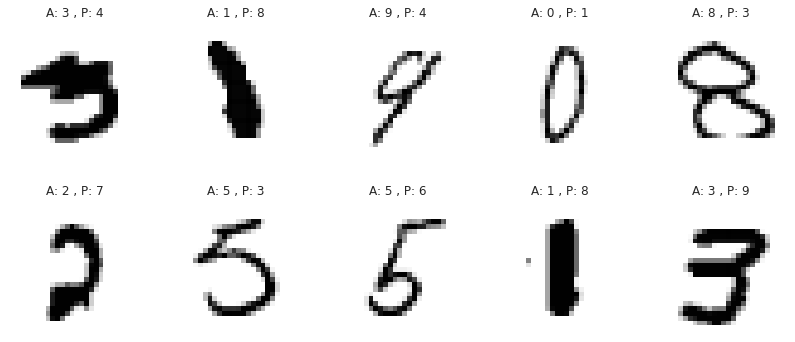

In [30]:
(
    true_wrong, incorrect_examples, pred_wrong
 ) = get_incorrect_preds(model, test_dataloader)
plot_incorrect_preds(true_wrong, incorrect_examples, pred_wrong)

In [31]:
del model, optimizer, scheduler

# Analysis

In [32]:
logs_df = pd.DataFrame(logs)
logs_df

,epoch,train_losses,test_losses,train_acc,test_acc,exp
0,0,0.180072,0.065323,88.582272,97.80,batch norm only
1,1,0.069678,0.044287,97.758540,98.62,batch norm only
2,2,0.056898,0.043622,98.127519,98.61,batch norm only
3,3,0.047008,0.046329,98.508397,98.47,batch norm only
4,4,0.045924,0.033986,98.460602,98.96,batch norm only
...,...,...,...,...,...,...
95,15,4.117834,0.250327,90.413479,92.38,Batch norm and L1 (low lambda)
96,16,4.091261,0.240656,90.574219,92.60,Batch norm and L1 (low lambda)
97,17,4.087134,0.239743,90.790708,92.60,Batch norm and L1 (low lambda)
98,18,4.086315,0.241347,91.005075,92.60,Batch norm and L1 (low lambda)


In [33]:
import seaborn as sns
sns.set(rc={'figure.figsize':(8, 6)})

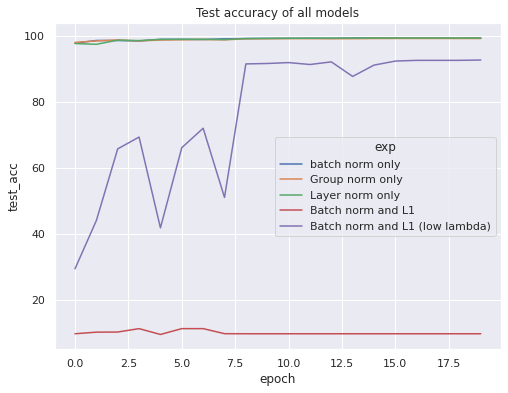

In [34]:
plt.title('Test accuracy of all models')
sns.lineplot(data=logs_df, x='epoch', y='test_acc', hue='exp')

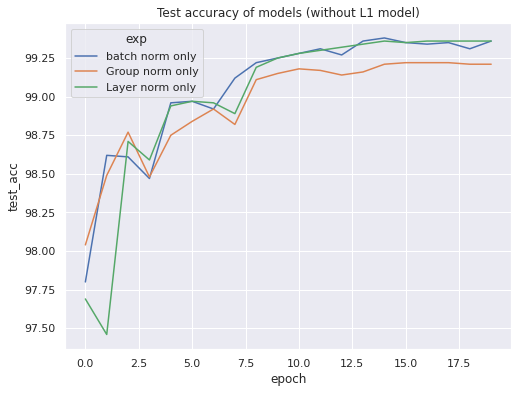

In [36]:
plt.title('Test accuracy of models (without L1 model)')
sns.lineplot(
    data=logs_df[
                 (logs_df.exp!='Batch norm and L1') &
                 (logs_df.exp!='Batch norm and L1 (low lambda)')
                 ], 
    x='epoch', y='test_acc', hue='exp'
)

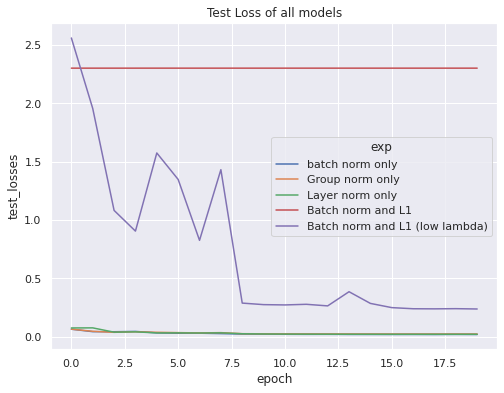

In [37]:
plt.title('Test Loss of all models')
sns.lineplot(data=logs_df, x='epoch', y='test_losses', hue='exp')

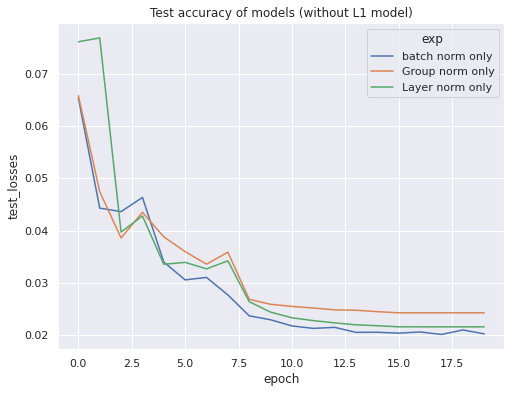

In [38]:
plt.title('Test accuracy of models (without L1 model)')
sns.lineplot(
    data=logs_df[
                  (logs_df.exp!='Batch norm and L1') &
                 (logs_df.exp!='Batch norm and L1 (low lambda)')
                 ], 
    x='epoch', y='test_losses', hue='exp'
)